<a href="https://colab.research.google.com/github/DaniCFraq/cicd-clientrepo/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/craft/
  inflating: data/craft/11319941.txt  
  inflating: data/craft/11532192.txt  
  inflating: data/craft/11597317.txt  
  inflating: data/craft/11604102.txt  
  inflating: data/craft/11897010.txt  
  inflating: data/craft/12079497.txt  
  inflating: data/craft/12546709.txt  
  inflating: data/craft/12585968.txt  
  inflating: data/craft/12925238.txt  
  inflating: data/craft/14609438.txt  
  inflating: data/craft/14611657.txt  
  inflating: data/craft/14624252.txt  
  inflating: data/craft/14675480.txt  
  inflating: data/craft/14691534.txt  
  inflating: data/craft/14723793.txt  
  inflating: data/craft/14737183.txt  
  inflating: data/craft/15005800.txt  
  inflating: data/craft/15018652.txt  
  inflating: data/craft/15040800.txt  
  inflating: data/craft/15061865.txt  
  inflating: data/craft/15070402.txt  
  inflating: data/craft/15207008.txt  
  inflating: data/craft/15238161.txt  
  inflating: data/craft/1531465

In [2]:
import torch

CRAFT_DIR = "data/craft/"
ONTOLOGY_PATH = "data/go/go.obo"
MAX_NUM_ARTICLES = 25 # None

device = "cuda" if torch.cuda.is_available() else "cpu"

## TASK 1

In [3]:
import re
def clean_bio_text(text):
    text = re.split(r'\n\s*(?:References|LITERATURE CITED|BIBLIOGRAPHY)\s*\n', text, flags=re.IGNORECASE)[0]
    text = re.sub(r'\'', '', text) # removes single quotes
    text = re.sub(r'\[\d+(?:[-,\s]+\d+)*\]', '', text) # removes numerical citations like [12], [3,4]

    lines = text.split('\n')
    cleaned_lines = []

    for line in lines:
        stripped_line = line.strip()
        word_count = len(stripped_line.split())

        if word_count >= 5:
            cleaned_lines.append(stripped_line)
    text = '\n'.join(cleaned_lines)

    text = re.sub(r'[ \t]+', ' ', text) # normalize whitespaces

    return text.strip()

In [4]:
import os

def load_craft_articles():
    articles = []
    article_ids = []
    for i, article_name in enumerate(sorted(os.listdir(CRAFT_DIR))):
        if MAX_NUM_ARTICLES is not None and i >= MAX_NUM_ARTICLES:
            break
        with open(os.path.join(CRAFT_DIR, article_name), "r", encoding="utf-8") as file:
            text = file.read()
        cleaned_text = clean_bio_text(text)
        articles.append(cleaned_text) # experimentar preprocessings
        article_ids.append(article_name)
    return articles, article_ids

articles, article_ids = load_craft_articles()
first_article_id, first_article = article_ids[0], articles[0]
print(first_article_id)
print(first_article[:500:]) #First 500 chars from first article

11319941.txt
Complex trait analysis of the mouse striatum: independent QTLs modulate volume and neuron number
The striatum plays a pivotal role in modulating motor activity and higher cognitive function. We analyzed variation in striatal volume and neuron number in mice and initiated a complex trait analysis to discover polymorphic genes that modulate the structure of the basal ganglia.
Brain weight, brain and striatal volume, neuron-packing density and number were estimated bilaterally using unbiased stereo


In [5]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

MIN_SCORE_THRESHOLD = 0.50
# Only keep entities that map to GO concepts

# https://huggingface.co/d4data/biomedical-ner-all
# pruas/BENT-PubMedBERT-NER-Bioprocess
# alvaroalon2/biobert_genetic_ner
model_name="pruas/BENT-PubMedBERT-NER-Bioprocess"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
print(model)
token_labels = model.config.label2id.keys()
print(token_labels)
#entity_types = set([t.split("-")[1] for t in token_labels if t != "O"])

#print(entity_types)
pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="none", device=device) # pass device=0 if using gpu
# experimentar outros parametros ou ate modelos

def split_text_by_tokens(text, tokenizer, max_length=512):
    """
    Split raw text into chunks such that each chunk, when tokenized with
    add_special_tokens=True, has length <= max_length.
    """
    words = text.split()
    chunks = []
    current_words = []

    for w in words:
        if not current_words:
            # Start a new chunk with this word
            candidate_text = w
        else:
            candidate_text = " ".join(current_words + [w])

        # IMPORTANT: no truncation here
        enc = tokenizer(candidate_text, add_special_tokens=True)
        length = len(enc["input_ids"])

        if length <= max_length:
            # Safe to add this word to current chunk
            if not current_words:
                current_words = [w]
            else:
                current_words.append(w)
        else:
            # Close current chunk and start a new one with this word
            if current_words:
                chunks.append(" ".join(current_words))
                current_words = [w]
            else:
                # Edge case: a single "word" is longer than max_length by itself.
                # This can happen with long sequences (e.g. DNA string). As a simple
                # fallback, just hard-split the text of this word.
                long_text = w
                while long_text:
                    # Take a slice and ensure it's within max_length in tokens
                    slice_size = min(len(long_text), 1000)  # heuristic
                    sub = long_text[:slice_size]
                    sub_enc = tokenizer(sub, add_special_tokens=True)
                    while len(sub_enc["input_ids"]) > max_length and slice_size > 1:
                        slice_size //= 2
                        sub = long_text[:slice_size]
                        sub_enc = tokenizer(sub, add_special_tokens=True)
                    chunks.append(sub)
                    long_text = long_text[slice_size:]
                current_words = []

    if current_words:
        chunks.append(" ".join(current_words))

    return chunks

def process_article_in_chunks(article, pipe, tokenizer, max_length=512):
    text_chunks = split_text_by_tokens(article, tokenizer, max_length=max_length)

    all_entities = []
    for chunk in text_chunks:
        # No truncation / max_length kwargs here (your transformers version complains)
        chunk_entities = pipe(chunk)
        all_entities.extend(chunk_entities)

    return all_entities

def merge_bio_entities(raw_tokens):
    entities = []
    current = None

    for tok in raw_tokens:
        label = tok["entity_group"] if "entity_group" in tok else tok["entity"]

        if label == "B":
            # Start a new entity
            if current:
                entities.append(current)

            current = {
                "word": tok["word"],
                "start": tok["start"],
                "end": tok["end"],
                "scores": [float(tok["score"])],
            }

        elif label == "I" and current:
            # Continue existing entity
            current["word"] += tok["word"] if tok["word"].startswith(" ") else " " + tok["word"]
            current["end"] = tok["end"]
            current["scores"].append(float(tok["score"]))

        else:
            # label == "O" or unexpected, close current
            if current:
                entities.append(current)
                current = None

    # Close final entity
    if current:
        entities.append(current)

    return entities

ner_output_per_article = []

for article_id, article in zip(article_ids, articles):
    raw = process_article_in_chunks(article, pipe, tokenizer)
    entities = merge_bio_entities(raw)
    ner_output_per_article.append({
        "article_id": article_id,
        "entities": entities
    })

filtered_ner_output = []

for article in ner_output_per_article:
    article_id = article["article_id"]
    original_entities = article["entities"]

    valid_entities = []

    for ent in original_entities:
        if "scores" in ent:
            ent_score = sum(ent["scores"]) / len(ent["scores"])
        else:
            ent_score = ent.get("score", 0.0)

        if ent_score < MIN_SCORE_THRESHOLD:
            continue

        valid_entities.append(ent)

    filtered_ner_output.append({
        "article_id": article_id,
        "entities": valid_entities
    })

ner_output_per_article = filtered_ner_output
ner_output_per_article
# filtrar entities que façam sentido para a GO ontology

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Device set to use cuda


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'article_id': '11319941.txt',
  'entities': [{'word': 'modulate',
    'start': 63,
    'end': 71,
    'scores': [0.99894779920578]},
   {'word': 'modulating',
    'start': 134,
    'end': 144,
    'scores': [0.9977990984916687]},
   {'word': 'cognitive',
    'start': 171,
    'end': 180,
    'scores': [0.9969820380210876]},
   {'word': 'modulate',
    'start': 332,
    'end': 340,
    'scores': [0.9989619255065918]},
   {'word': 'modulate',
    'start': 1583,
    'end': 1591,
    'scores': [0.9990600943565369]},
   {'word': 'modulating',
    'start': 1718,
    'end': 1728,
    'scores': [0.9980555772781372]},
   {'word': 'cognitive',
    'start': 1755,
    'end': 1764,
    'scores': [0.9969503283500671]},
   {'word': 'gene expression',
    'start': 2087,
    'end': 2102,
    'scores': [0.9940890073776245, 0.9971097111701965]},
   {'word': 'cognition',
    'start': 2342,
    'end': 2351,
    'scores': [0.9934377074241638]},
   {'word': 'control',
    'start': 2570,
    'end': 2577,
  

## TASK 2

In [6]:
def encode_article_in_chunks(article, tokenizer, model, max_length=512):
    inputs = tokenizer(article, return_offsets_mapping=True, add_special_tokens=True, truncation=True,
                       max_length=max_length, return_overflowing_tokens=True, return_tensors=None)
    input_ids_chunks = inputs["input_ids"]
    offsets_chunks = inputs["offset_mapping"]

    all_hidden = []
    all_offsets = []

    for ids, offsets in zip(input_ids_chunks, offsets_chunks):
        input_tensor = torch.tensor([ids], device=device)
        mask_tensor = torch.ones_like(input_tensor, device=device)

        with torch.no_grad():
            model_output = model(input_tensor, mask_tensor, output_hidden_states=True)

        hidden_states = model_output.hidden_states[-1].squeeze(0)
        hidden_states = hidden_states[1:-1]
        offsets = offsets[1:-1]

        all_hidden.append(hidden_states)
        all_offsets.extend(offsets)

    all_hidden = torch.cat(all_hidden)

    return all_hidden, all_offsets

last_hidden_state_per_article = {}
offset_mapping_per_article = {}

for article_id, article in zip(article_ids, articles):
    last_hidden_state, offsets = encode_article_in_chunks(article, tokenizer, model)
    last_hidden_state_per_article[article_id] = last_hidden_state
    offset_mapping_per_article[article_id] = offsets


In [7]:
import numpy as np

def get_entity_embbedings_for_article(article_id, ner_entities, last_hidden_state, offset_mapping):
    entity_embeddings_averaged = []

    # Iterate through each identified entity
    for entity in ner_entities:
        current_entity_token_embeddings = []
        #current_entity_tokens = []

        # Iterate through tokens and their character offsets to find those belonging to the current entity
        for idx, (char_start, char_end) in enumerate(offset_mapping):
            # Check if the token's character span is fully contained within the entity's character span
            if (char_start >= entity['start'] and
                char_end <= entity['end'] and
                char_start < char_end):

                current_entity_token_embeddings.append(last_hidden_state[idx].cpu().numpy())
                #current_entity_tokens.append(tokenizer.decode(input_ids[token_idx]))

        # If embeddings were found for the entity's tokens, add them to the list
        if current_entity_token_embeddings:
            averaged_embedding = np.mean(np.stack(current_entity_token_embeddings, axis=0), axis=0)
        else:
            averaged_embedding = None

        entity_embeddings_averaged.append({
            #"article_id": article_id,
            #"entity_group": entity['entity_group'],
            "word":  entity['word'],
            "start": entity['start'],
            "end": entity['end'],
            #"tokens": current_entity_tokens,
            "averaged_embedding": averaged_embedding
        })

    return entity_embeddings_averaged

all_entities_embeddings_per_article = []

for article in ner_output_per_article:
    article_id = article["article_id"]
    ner_entities = article["entities"]

    last_hidden_state = last_hidden_state_per_article[article_id]
    offset_mapping = offset_mapping_per_article[article_id]

    entity_embeddings = get_entity_embbedings_for_article(article_id, ner_entities, last_hidden_state, offset_mapping)

    all_entities_embeddings_per_article.append({
        "article_id": article_id,
        "entities": entity_embeddings
        })

for article_entry in all_entities_embeddings_per_article:
    article_id = article_entry["article_id"]
    entity_embeddings_averaged = article_entry["entities"]
    print(f"Article: {article_id}")

    for entry in entity_embeddings_averaged:
        #print(f"\tEntity: '{entry['word']}' (Type: {entry['entity_group']})")
        print(f"\tEntity: '{entry['word']}'")
        print(f"\t\tAveraged Embedding Shape: {entry['averaged_embedding'].shape if entry['averaged_embedding'] is not None else 'None'}")
        print("\n")

Article: 11319941.txt
	Entity: 'modulate'
		Averaged Embedding Shape: (768,)


	Entity: 'modulating'
		Averaged Embedding Shape: (768,)


	Entity: 'cognitive'
		Averaged Embedding Shape: (768,)


	Entity: 'modulate'
		Averaged Embedding Shape: (768,)


	Entity: 'modulate'
		Averaged Embedding Shape: (768,)


	Entity: 'modulating'
		Averaged Embedding Shape: (768,)


	Entity: 'cognitive'
		Averaged Embedding Shape: (768,)


	Entity: 'gene expression'
		Averaged Embedding Shape: (768,)


	Entity: 'cognition'
		Averaged Embedding Shape: (768,)


	Entity: 'control'
		Averaged Embedding Shape: (768,)


	Entity: 'proliferation'
		Averaged Embedding Shape: (768,)


	Entity: 'modulate'
		Averaged Embedding Shape: (768,)


	Entity: 'neuro'
		Averaged Embedding Shape: None


	Entity: '##gene'
		Averaged Embedding Shape: None


	Entity: '##tic'
		Averaged Embedding Shape: None


	Entity: 'control'
		Averaged Embedding Shape: None


	Entity: 'control of tele'
		Averaged Embedding Shape: (768,)


	

In [8]:
%pip install pronto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.4 MB/s eta 0:00:00


In [9]:
import pronto
import pandas as pd

def load_go_ontology():
    ont = pronto.Ontology(ONTOLOGY_PATH)
    concepts = []

    for term in ont.terms():
      if term.namespace == "biological_process":
        concepts.append({
            "Class ID": term.id,
            "Preferred Label": term.name,
            #"Namespace": term.namespace
            #"Synonyms": [syn.description for syn in term.synonyms]
        })

    return pd.DataFrame(concepts)

go_concepts = load_go_ontology()
print(go_concepts.head(10))
print(len(go_concepts))

     Class ID                            Preferred Label
0  GO:0000001                  mitochondrion inheritance
1  GO:0000002  obsolete mitochondrial genome maintenance
2  GO:0000003                      obsolete reproduction
3  GO:0008033                            tRNA processing
4  GO:0008037                           cell recognition
5  GO:0008038                         neuron recognition
6  GO:0008039                synaptic target recognition
7  GO:0008044    obsolete adult behavior (sensu Insecta)
8  GO:0008045                 motor neuron axon guidance
9  GO:0008049                    male courtship behavior
30817


In [10]:
all_entities_embedding_flat = [entity for article in all_entities_embeddings_per_article for entity in article["entities"]]
all_word_entities = list({entity["word"] for entity in all_entities_embedding_flat})

In [11]:
go_embeddings = []

for label in go_concepts["Preferred Label"]:
    inputs = tokenizer(label, return_tensors="pt", add_special_tokens=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        model_output = model(**inputs, output_hidden_states=True)

    last_hidden_state = model_output.hidden_states[-1].squeeze(0).cpu().numpy()
    averaged_embedding = np.mean(last_hidden_state, axis=0)
    go_embeddings.append(averaged_embedding)

go_concepts['Embedding'] = go_embeddings

ontology_embeddings = go_concepts['Embedding'].tolist()
ontology_ids = go_concepts['Class ID'].tolist()
ontology_labels = go_concepts['Preferred Label'].tolist()

print(f"Number of valid ontology embeddings: {len(ontology_embeddings)}")
print(f"Number of corresponding ontology IDs: {len(ontology_ids)}")
print(f"Shape of first ontology embedding: {ontology_embeddings[0].shape if ontology_embeddings else 'N/A'}")

go_concepts.head(10)

Number of valid ontology embeddings: 30817
Number of corresponding ontology IDs: 30817
Shape of first ontology embedding: (768,)


,Class ID,Preferred Label,Embedding
0,GO:0000001,mitochondrion inheritance,"[-0.51058674, 0.20994909, 0.9149475, -0.599133..."
1,GO:0000002,obsolete mitochondrial genome maintenance,"[-0.8647392, 0.23350857, 0.7951232, -0.6939640..."
2,GO:0000003,obsolete reproduction,"[-0.8713908, 0.3412703, 0.80295205, -0.5790219..."
3,GO:0008033,tRNA processing,"[-0.39227164, 0.36014187, 1.1763854, -0.104829..."
4,GO:0008037,cell recognition,"[-0.34329504, -0.027894525, 0.7392482, -0.5992..."
5,GO:0008038,neuron recognition,"[-0.70865417, 0.105862506, 0.81645364, -0.5059..."
6,GO:0008039,synaptic target recognition,"[-0.5865813, 0.10664096, 0.7356519, -0.6492215..."
7,GO:0008044,obsolete adult behavior (sensu Insecta),"[-0.2979949, -0.01805553, 0.46097293, -0.65940..."
8,GO:0008045,motor neuron axon guidance,"[-0.37012315, 0.51754326, 1.0022885, -0.481107..."
9,GO:0008049,male courtship behavior,"[-0.46968523, 0.38414404, 0.71314645, -0.49682..."


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def link_entity_to_go(entity, ontology_embeddings_array):
    entity_embedding = entity['averaged_embedding']

    # Reshape the entity embedding for cosine_similarity function
    entity_embedding_reshaped = entity_embedding.reshape(1, -1)

    # Calculate cosine similarity between the entity embedding and all ontology embeddings
    similarities = cosine_similarity(entity_embedding_reshaped, ontology_embeddings_array)

    # Get the maximum similarity score and its index
    best_similarity_score = np.max(similarities)
    best_match_index = np.argmax(similarities)

    # Retrieve the best matching ontology details
    best_match_ontology_id = ontology_ids[best_match_index]
    best_match_preferred_label = ontology_labels[best_match_index]

    return {
        "entity_word": entity['word'],
        #"entity_group": entity['entity_group'],
        "best_match_ontology_id": best_match_ontology_id,
        "best_match_preferred_label": best_match_preferred_label,
        "best_similarity_score": best_similarity_score
    }

In [ ]:
ontology_embeddings_array = np.array(ontology_embeddings)

best_matches_for_entities = []

for entity in all_entities_embedding_flat:
    # Skip entities that do not have a valid embedding
    if entity['averaged_embedding'] is None:
        continue
    best_matches_for_entities.append(link_entity_to_go(entity, ontology_embeddings_array))

for match in best_matches_for_entities:
    #print(f"Document Entity: '{match['entity_word']}' (Type: {match['entity_group']})")
    print(f"Document Entity: '{match['entity_word']}'")
    print(f"Best Ontology Match: '{match['best_match_preferred_label']}' (ID: {match['best_match_ontology_id']})")
    print(f"Similarity Score: {match['best_similarity_score']:.4f}")
    print("\n")

In [17]:
print(len(best_matches_for_entities))

""" from sklearn.metrics.pairwise import cosine_similarity

best_matches_for_entities = []

# Convert ontology_embeddings to a NumPy array once for efficiency
ontology_embeddings_array = np.array(ontology_embeddings)

for entity in all_entities_embedding_flat:
    entity_embedding = entity['averaged_embedding']

    # Reshape the entity embedding for cosine_similarity function
    entity_embedding_reshaped = entity_embedding.reshape(1, -1)

    # Calculate cosine similarity between the entity embedding and all ontology embeddings
    similarities = cosine_similarity(entity_embedding_reshaped, ontology_embeddings_array)

    # Get the maximum similarity score and its index
    best_similarity_score = np.max(similarities)
    best_match_index = np.argmax(similarities)

    # Retrieve the best matching ontology details
    best_match_ontology_id = ontology_ids[best_match_index]
    best_match_preferred_label = ontology_labels[best_match_index]

    best_matches_for_entities.append({
        "entity_word": entity['word'],
        "entity_group": entity['entity_group'],
        "best_match_ontology_id": best_match_ontology_id,
        "best_match_preferred_label": best_match_preferred_label,
        "best_similarity_score": best_similarity_score
    })

for match in best_matches_for_entities:
    print(f"Document Entity: '{match['entity_word']}' (Type: {match['entity_group']})")
    print(f"  Best Ontology Match: '{match['best_match_preferred_label']}' (ID: {match['best_match_ontology_id']})")
    print(f"  Similarity Score: {match['best_similarity_score']:.4f}")
    print("\n") """

1991


' from sklearn.metrics.pairwise import cosine_similarity\n\nbest_matches_for_entities = []\n\n# Convert ontology_embeddings to a NumPy array once for efficiency\nontology_embeddings_array = np.array(ontology_embeddings)\n\nfor entity in all_entities_embedding_flat:\n    entity_embedding = entity[\'averaged_embedding\']\n\n    # Reshape the entity embedding for cosine_similarity function\n    entity_embedding_reshaped = entity_embedding.reshape(1, -1)\n\n    # Calculate cosine similarity between the entity embedding and all ontology embeddings\n    similarities = cosine_similarity(entity_embedding_reshaped, ontology_embeddings_array)\n\n    # Get the maximum similarity score and its index\n    best_similarity_score = np.max(similarities)\n    best_match_index = np.argmax(similarities)\n\n    # Retrieve the best matching ontology details\n    best_match_ontology_id = ontology_ids[best_match_index]\n    best_match_preferred_label = ontology_labels[best_match_index]\n\n    best_matches_for

## TASK 3

In [ ]:
best_matches_for_entities_per_article = []

article2go = {}

for article in all_entities_embeddings_per_article:
    article_id = article["article_id"]

    for entity in article["entities"]:
        # Skip entities that do not have a valid embedding
        if entity['averaged_embedding'] is None:
            continue

        match = link_entity_to_go(entity, ontology_embeddings_array)
        match["article_id"] = article_id
        best_matches_for_entities_per_article.append(match)

        if match["best_match_ontology_id"] is not None:
          if article_id not in article2go:
            article2go[article_id] = set()

          article2go[article_id].add(match["best_match_ontology_id"])

article2go

In [ ]:
import networkx as nx
from itertools import combinations

id2label = dict(zip(ontology_ids, ontology_labels))

ontology_network = nx.Graph()

for article_id, go_ids in article2go.items():
    go_ids = list(go_ids)

    for go_id in go_ids:
        if go_id not in ontology_network:
            ontology_network.add_node(go_id, label=id2label.get(go_id))

    for go_1, go_2 in combinations(go_ids, 2):
        if ontology_network.has_edge(go_1, go_2):
            ontology_network[go_1][go_2]["weight"] += 1
        else:
            ontology_network.add_edge(go_1, go_2, weight=1)

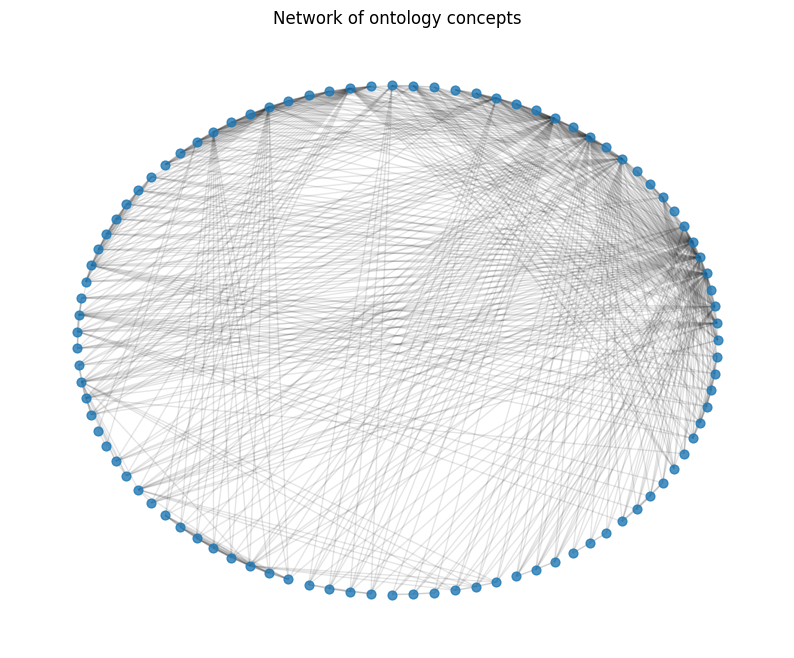

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(ontology_network, k=0.3, seed=42)
#pos = nx.circular_layout(ontology_network)

nx.draw_networkx_nodes(ontology_network, pos, node_size=40, alpha=0.8)
nx.draw_networkx_edges(ontology_network, pos, alpha=0.1)

plt.title("Network of ontology concepts")
plt.axis("off")
plt.show()


In [ ]:
degree_sorted = sorted(ontology_network.degree(weight="weight"), key=lambda x: x[1], reverse=True)
#print(degree_sorted[:10])
print("Top 5 concepts by weight")
for go in degree_sorted[:5]:
  go_id = go[0]
  print(f"\t{id2label[go_id]} ({go_id}) - {go[1]}")

bet = nx.betweenness_centrality(ontology_network, weight="weight")
bet_sorted = sorted(bet.items(), key=lambda x: x[1], reverse=True)
#print(bet_sorted[:10])
print("\nTop 5 concepts by centrality")
for go in bet_sorted[:5]:
  go_id = go[0]
  print(f"\t{id2label[go_id]} ({go_id}) - {go[1]}")

pr = nx.pagerank(ontology_network, weight="weight")
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)
#print(pr_sorted[:10])
print("\nTop 5 concepts by page rank")
for go in pr_sorted[:5]:
  go_id = go[0]
  print(f"\t{id2label[go_id]} ({go_id}) - {go[1]}")

Top 5 concepts by weight
	synaptotagmin-synaptobrevin 2-SNAP-25-syntaxin-1a-syntaxin-1b-Unc13 complex (GO:0070768) - 140
	phosphatidylinositol 3-kinase complex (GO:0005942) - 123
	hydroxyproline O-arabinosyltransferase activity (GO:1990585) - 122
	protocadherin-alpha-protocadherin-gamma complex (GO:0071183) - 91
	inositol phosphoceramide synthase complex (GO:0070916) - 91

Top 5 concepts by centrality
	synaptotagmin-synaptobrevin 2-SNAP-25-syntaxin-1a-syntaxin-1b-Unc13 complex (GO:0070768) - 0.20186511251653413
	phosphatidylinositol 3-kinase complex (GO:0005942) - 0.11668573563476785
	hydroxyproline O-arabinosyltransferase activity (GO:1990585) - 0.10290095738203243
	TIM23 mitochondrial import inner membrane translocase complex (GO:0005744) - 0.08667976586449903
	glycosylphosphatidylinositol-mannosyltransferase II complex (GO:0120097) - 0.0647911049222237

Top 5 concepts by page rank
	synaptotagmin-synaptobrevin 2-SNAP-25-syntaxin-1a-syntaxin-1b-Unc13 complex (GO:0070768) - 0.063981137

## TASK 4

In [ ]:
documents_network = nx.Graph()

articles = list(article2go.keys())

for article in articles:
    documents_network.add_node(article)

for article1, article2 in combinations(articles, 2):
    shared = article2go[article1].intersection(article2go[article2])

    if len(shared) > 0:
        documents_network.add_edge(article1, article2, weight=len(shared))

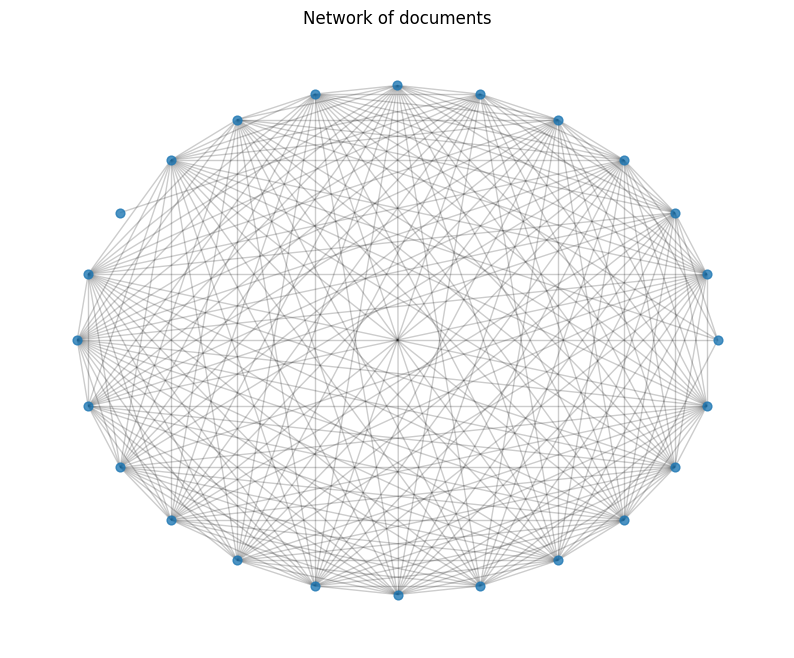

In [ ]:
plt.figure(figsize=(10, 8))
#pos = nx.spring_layout(documents_network, k=0.3, seed=42)
pos = nx.circular_layout(documents_network)

nx.draw_networkx_nodes(documents_network, pos, node_size=40, alpha=0.8)
nx.draw_networkx_edges(documents_network, pos, alpha=0.2)

plt.title("Network of documents")
plt.axis("off")
plt.show()